# JCC2 Application-Section Rating Matrix

This notebook creates comprehensive tables and visualizations showing application ratings across different JCC2 sections.

**Legend:**
- **x**: Application is not applicable to this section
- **\***: Application is applicable but no data available
- **Number**: Average rating score (1-6 scale)
- **N/A**: User indicated "Not Applicable" for this question

In [63]:
import sys
import os

# Add the parent directory to the path
sys.path.insert(0, os.path.abspath('..'))

# Import the processor module
from jcc2_data_processor import create_processor

In [64]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Define consistent color scheme
COLORS = {
    'primary': '#1f77b4',
    'secondary': '#ff7f0e',
    'tertiary': '#9467bd',
    'success': '#2ca02c',
    'danger': '#d62728',
    'warning': '#ff9800',
    'info': '#17a2b8',
    'gray': '#7f7f7f'
}

In [65]:
# Load data files
data_files = {
  "JCC2 OUE - DCDC - User Questionnaires": "/home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/DCDC UQ Combined_2025-07-30_pii_scrubbed.csv",
  "JCC2 OUE - CNMF - User Questionnaires": "/home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/CNMF UQ Combined_2025-08-03_pii_scrubbed.csv",
  "JCC2 OUE - COGUARD - User Questionnaires": "/home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/GOGUARD UQ Combined_2025-08-03_pii_scrubbed.csv",
  "JCC2 OUE - Phase 1 - User Questionnaires": "/home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/DCDC_CNMF_GOGUARD UQ Combined_2025-08-03_pii_scrubbed.csv"
}

# Initialize processors and dataframes
processors = {}
dataframes = {}
for name, filepath in data_files.items():
    try:
        processors[name] = create_processor(filepath)
        dataframes[name] = processors[name].load_data()
        print(f"\n{name}:")
        print(f"  - Data loaded: {len(dataframes[name])} responses, {len(dataframes[name].columns)} fields")
        if 'user_information.date' in dataframes[name].columns:
            print(f"  - Date range: {dataframes[name]['user_information.date'].min()} to {dataframes[name]['user_information.date'].max()}")
    except Exception as e:
        print(f"\nError loading {name}: {e}")

2025-08-03 12:40:01,484 - INFO - Detected User Questionnaire format
2025-08-03 12:40:01,484 - INFO - Loading data from /home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/DCDC UQ Combined_2025-07-30_pii_scrubbed.csv
2025-08-03 12:40:01,492 - INFO - Parsing field schemas
2025-08-03 12:40:01,496 - INFO - Loaded 21 data rows with 667 columns
2025-08-03 12:40:01,496 - INFO - Found 28 sections and 6 system columns
2025-08-03 12:40:01,511 - INFO - Detected User Questionnaire format
2025-08-03 12:40:01,511 - INFO - Loading data from /home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/CNMF UQ Combined_2025-08-03_pii_scrubbed.csv
2025-08-03 12:40:01,521 - INFO - Parsing field schemas
2025-08-03 12:40:01,527 - INFO - Loaded 6 data rows with 667 columns
2025-08-03 12:40:01,527 - INFO - Found 28 sections and 6 system columns
2025-08-03 12:40:01,548 - INFO - Detected User Questionnaire format
2025-08-03 12:40:01,549 - INFO - Load


JCC2 OUE - DCDC - User Questionnaires:
  - Data loaded: 21 responses, 667 fields
  - Date range: 2025-06-23 to 2025-06-25

JCC2 OUE - CNMF - User Questionnaires:
  - Data loaded: 6 responses, 667 fields
  - Date range: 2025-06-26 to 2025-06-26

JCC2 OUE - COGUARD - User Questionnaires:
  - Data loaded: 6 responses, 667 fields
  - Date range: 2025-06-30 to 2025-06-30

JCC2 OUE - Phase 1 - User Questionnaires:
  - Data loaded: 33 responses, 667 fields
  - Date range: 2025-06-23 to 2025-06-30


In [66]:
# Define the target sections as requested
target_sections = [
    'mop_1_1_1',
    'mos_1_1_2',
    'mop_1_1_3',
    'reporting_and_data_export',
    'mop_1_1_5',
    'mop_1_2_1',
    'mop_1_2_2',
    'mos_1_3_1',
    'mop_1_3_2',
    'mop_1_3_3',
    'mop_1_3_4',
    'mop_1_3_5',
    'mop_2_1_1',
    'mop_2_1_2',
    'mop_2_1_7',
    'mop_2_1_9',
    'mop_2_3_1',
    'mop_2_3_2',
    'mop_2_4_1',
    'mos_3_2_1',
    'mos_3_2_2',
    'mop_3_2_3'
]

# Define all applications - include variations that might appear in field names
all_applications = [
    'a2it', 'cad', 'codex', 'crucible', 'cyber9line', 'dispatch',
    'jcc2cyberops', 'jcc2readiness', 'madss', 'rally', 'redmap',
    'sigact', 'threathub', 'triage', 'unity'
]

# Also check for variations
app_variations = {
    'cyber9line': ['cyber9line', 'cyber_9line', 'cyber-9line'],
    'jcc2cyberops': ['jcc2cyberops', 'jcc2_cyberops', 'jcc2-cyberops', 'cyberops'],
    'jcc2readiness': ['jcc2readiness', 'jcc2_readiness', 'jcc2-readiness', 'readiness'],
    'threathub': ['threathub', 'threat_hub', 'threat-hub']
}

# Create a reverse mapping from variation to canonical app name
variation_to_app = {}
for canonical_app, variations in app_variations.items():
    for variation in variations:
        variation_to_app[variation] = canonical_app

# Add standard apps that don't have variations
for app in all_applications:
    if app not in app_variations:
        variation_to_app[app] = app

# Create a comprehensive list of all possible app identifiers to check
all_app_identifiers = list(variation_to_app.keys())

# Display names for applications (proper formatting)
app_display_names = {
    'a2it': 'A2IT',
    'cad': 'CAD',
    'codex': 'Codex',
    'crucible': 'Crucible',
    'cyber9line': 'Cyber 9-Line',
    'dispatch': 'Dispatch',
    'jcc2cyberops': 'JCC2 Cyber Ops',
    'jcc2readiness': 'JCC2 Readiness',
    'madss': 'MADSS',
    'rally': 'Rally',
    'redmap': 'REDMAP',
    'sigact': 'SigAct',
    'threathub': 'Threat Hub',
    'triage': 'Triage',
    'unity': 'Unity'
}

# Display names for sections
section_display_names = {
    'mop_1_1_1': 'MOP 1.1.1',
    'mos_1_1_2': 'MOS 1.1.2',
    'mop_1_1_3': 'MOP 1.1.3',
    'reporting_and_data_export': 'Reporting & Export',
    'mop_1_1_5': 'MOP 1.1.5',
    'mop_1_2_1': 'MOP 1.2.1',
    'mop_1_2_2': 'MOP 1.2.2',
    'mos_1_3_1': 'MOS 1.3.1',
    'mop_1_3_2': 'MOP 1.3.2',
    'mop_1_3_3': 'MOP 1.3.3',
    'mop_1_3_4': 'MOP 1.3.4',
    'mop_1_3_5': 'MOP 1.3.5',
    'mop_2_1_1': 'MOP 2.1.1',
    'mop_2_1_2': 'MOP 2.1.2',
    'mop_2_1_7': 'MOP 2.1.7',
    'mop_2_1_9': 'MOP 2.1.9',
    'mop_2_3_1': 'MOP 2.3.1',
    'mop_2_3_2': 'MOP 2.3.2',
    'mop_2_4_1': 'MOP 2.4.1',
    'mos_3_2_1': 'MOS 3.2.1',
    'mos_3_2_2': 'MOS 3.2.2',
    'mop_3_2_3': 'MOP 3.2.3'
}

In [67]:
# Helper function to extract app name from field
def get_app_from_field(field_name, section_prefix=""):
    """
    Extract app name from field, checking for various patterns and variations
    """
    # Remove section prefix if provided
    if section_prefix and field_name.startswith(section_prefix):
        field_without_section = field_name[len(section_prefix) :].lstrip(".")
    else:
        field_without_section = field_name

    # Check all apps and their variations
    for canonical_app in all_applications:
        # Get variations for this app (or just the app itself if no variations)
        variations = app_variations.get(canonical_app, [canonical_app])

        for variation in variations:
            # Check multiple patterns:
            # 1. Field ends with variation
            # 2. Field ends with _variation
            # 3. Field ends with -variation
            if (
                field_without_section.endswith(variation)
                or field_without_section.endswith(f"_{variation}")
                or field_without_section.endswith(f"-{variation}")
            ):
                return canonical_app

    return None

# Helper function to check for rating fields
def normalize_for_comparison(lst):
    """Convert list to set, treating all NaN types as equivalent"""
    result = set()
    for item in lst:
        if pd.isna(item):
            result.add('__NaN__')
        else:
            result.add(item)
    return result

# Define standard rating values
rating_values = [
    'Completely Ineffective',
    'Moderately Ineffective',
    'Slightly Ineffective',
    'Slightly Effective',
    'Moderately Effective',
    'Completely Effective',
    'Not Applicable',
    float('nan'),
    np.nan
]

normalized_rating_set = normalize_for_comparison(rating_values)

# Helper functions for data processing

In [68]:
# Define rating mappings
rating_map = {
    'Completely Ineffective': 1,
    'Moderately Ineffective': 2,
    'Slightly Ineffective': 3,
    'Slightly Effective': 4,
    'Moderately Effective': 5,
    'Completely Effective': 6
}

# Function to calculate average rating for a field
def calculate_field_rating(field_name, df):
    if field_name not in df.columns:
        return None, 0, 0
    
    # Determine which mapping to use
    mapping = rating_map
    
    # Get all values
    values = df[field_name]
    
    # Count N/A responses
    na_count = (values == 'NA').sum() + (values == 'N/A').sum() + (values == 'Not Applicable').sum()
    
    # Get valid ratings (not null and not N/A)
    valid_mask = values.notna() & ~values.isin(['NA', 'N/A', 'Not Applicable'])
    valid_values = values[valid_mask]
    
    if len(valid_values) == 0:
        return None, na_count, len(values) - values.isna().sum()
    
    # Map to numeric values
    numeric_values = valid_values.map(mapping).dropna()
    
    if len(numeric_values) == 0:
        return None, na_count, len(values) - values.isna().sum()
    
    return numeric_values.mean(), na_count, len(values) - values.isna().sum()

In [69]:
# Function to create rating matrix for a given dataset
def create_rating_matrix(df, processor, dataset_name="Dataset"):
    """Create a rating matrix for a specific dataset"""
    
    print(f"\nCreating matrix for: {dataset_name}")
    print("=" * 80)
    
    # First, analyze sections for this dataset
    section_field_analysis = {}
    
    for section in target_sections:
        if section in processor.sections:
            fields = processor.sections[section]
            field_analysis = {
                "total_fields": len(fields),
                "app_specific_fields": {},
                "overall_fields": [],
            }

            # Identify rating fields
            rating_fields = [
                field
                for field in fields
                if not df[field].apply(lambda x: isinstance(x, list)).any()
                and not normalize_for_comparison(df[field].unique()) - normalized_rating_set
            ]

            for field in rating_fields:
                app_found = False
                field_lower = field.lower()
                
                # Check for app-specific field
                detected_app = get_app_from_field(field, section_prefix=f"{section}")
                if detected_app:
                    if detected_app not in field_analysis["app_specific_fields"]:
                        field_analysis["app_specific_fields"][detected_app] = []
                    field_analysis["app_specific_fields"][detected_app].append(field)
                    app_found = True
                elif field == "mop_2_4_1.mission_progress_assessment":
                    detected_app = "jcc2cyberops"
                    if detected_app not in field_analysis["app_specific_fields"]:
                        field_analysis["app_specific_fields"][detected_app] = []
                    field_analysis["app_specific_fields"][detected_app].append(field)
                    app_found = True

                # If not app-specific, it's likely an overall field
                if not app_found:
                    if "overall" in field_lower:
                        field_analysis["overall_fields"].append(field)
                    else:
                        field_analysis["overall_fields"].append(field)

            section_field_analysis[section] = field_analysis
    
    # Create the rating matrix
    matrix_data = []
    row_labels = []

    # Process each application
    for app in all_applications:
        row_data = []
        row_labels.append(app_display_names.get(app, app))
        
        for section in target_sections:
            if section not in section_field_analysis:
                row_data.append('x')
                continue

            # Check if this app has fields in this section
            app_fields = section_field_analysis[section]['app_specific_fields'].get(app, [])
            
            if not app_fields:
                row_data.append('x')
            else:
                # Calculate average rating for all app-specific fields
                ratings = []
                total_responses = 0
                na_responses = 0
                
                for field in app_fields:
                    rating, na_count, total_count = calculate_field_rating(field, df)
                    if rating is not None:
                        ratings.append(rating)
                    total_responses += total_count
                    na_responses += na_count
                
                if ratings:
                    avg_rating = np.mean(ratings)
                    row_data.append(f"{avg_rating:.1f}")
                elif na_responses > 0 and na_responses == total_responses:
                    row_data.append('N/A')
                else:
                    row_data.append('*')
        
        matrix_data.append(row_data)

    # Add JCC2 Overall row
    overall_row = []
    row_labels.append('JCC2 Overall')

    for section in target_sections:
        if section not in section_field_analysis:
            overall_row.append('x')
            continue
        
        # Get overall fields for this section
        overall_fields = section_field_analysis[section]['overall_fields']
        
        if not overall_fields:
            overall_row.append('x')
        else:
            ratings = []
            total_responses = 0
            na_responses = 0
            
            for field in overall_fields:
                rating, na_count, total_count = calculate_field_rating(field, df)
                if rating is not None:
                    ratings.append(rating)
                total_responses += total_count
                na_responses += na_count
            
            if ratings:
                avg_rating = np.mean(ratings)
                overall_row.append(f"{avg_rating:.1f}")
            elif na_responses > 0 and na_responses == total_responses:
                overall_row.append('N/A')
            else:
                overall_row.append('*')

    matrix_data.append(overall_row)

    # Create DataFrame
    column_labels = [section_display_names.get(s, s) for s in target_sections]
    matrix_df = pd.DataFrame(matrix_data, index=row_labels, columns=column_labels)
    
    return matrix_df, matrix_data, row_labels, column_labels

# Matrix generation functions

In [70]:
# Generate matrices for all datasets
all_matrices = {}
all_matrix_data = {}

# Process each dataset
for dataset_name, df_data in dataframes.items():
    processor_obj = processors[dataset_name]
    
    matrix_df, matrix_data, row_labels, column_labels = create_rating_matrix(
        df_data, processor_obj, dataset_name
    )
    
    all_matrices[dataset_name] = matrix_df
    all_matrix_data[dataset_name] = {
        'matrix_data': matrix_data,
        'row_labels': row_labels,
        'column_labels': column_labels
    }
    
    # Display the matrix
    print(f"\n\nRating Matrix for {dataset_name}:")
    print("=" * 120)
    print(matrix_df)
    print("\n")


Creating matrix for: JCC2 OUE - DCDC - User Questionnaires


Rating Matrix for JCC2 OUE - DCDC - User Questionnaires:
               MOP 1.1.1 MOS 1.1.2 MOP 1.1.3 Reporting & Export MOP 1.1.5  \
A2IT                 4.6         x         x                4.0       4.3   
CAD                  N/A         x         x                1.0       N/A   
Codex                3.5         x         x                2.1       4.0   
Crucible             3.5         x         x                2.1       4.0   
Cyber 9-Line         3.5         x         x                2.1       4.0   
Dispatch             5.0         x         x                N/A       N/A   
JCC2 Cyber Ops       3.7         x         x                2.3       2.2   
JCC2 Readiness       4.0         x         x                4.3       4.2   
MADSS                3.8       3.2       3.0                3.3       2.2   
Rally                4.8       5.0         x                4.6       4.5   
REDMAP               4.0         x

# Generate matrices for all datasets

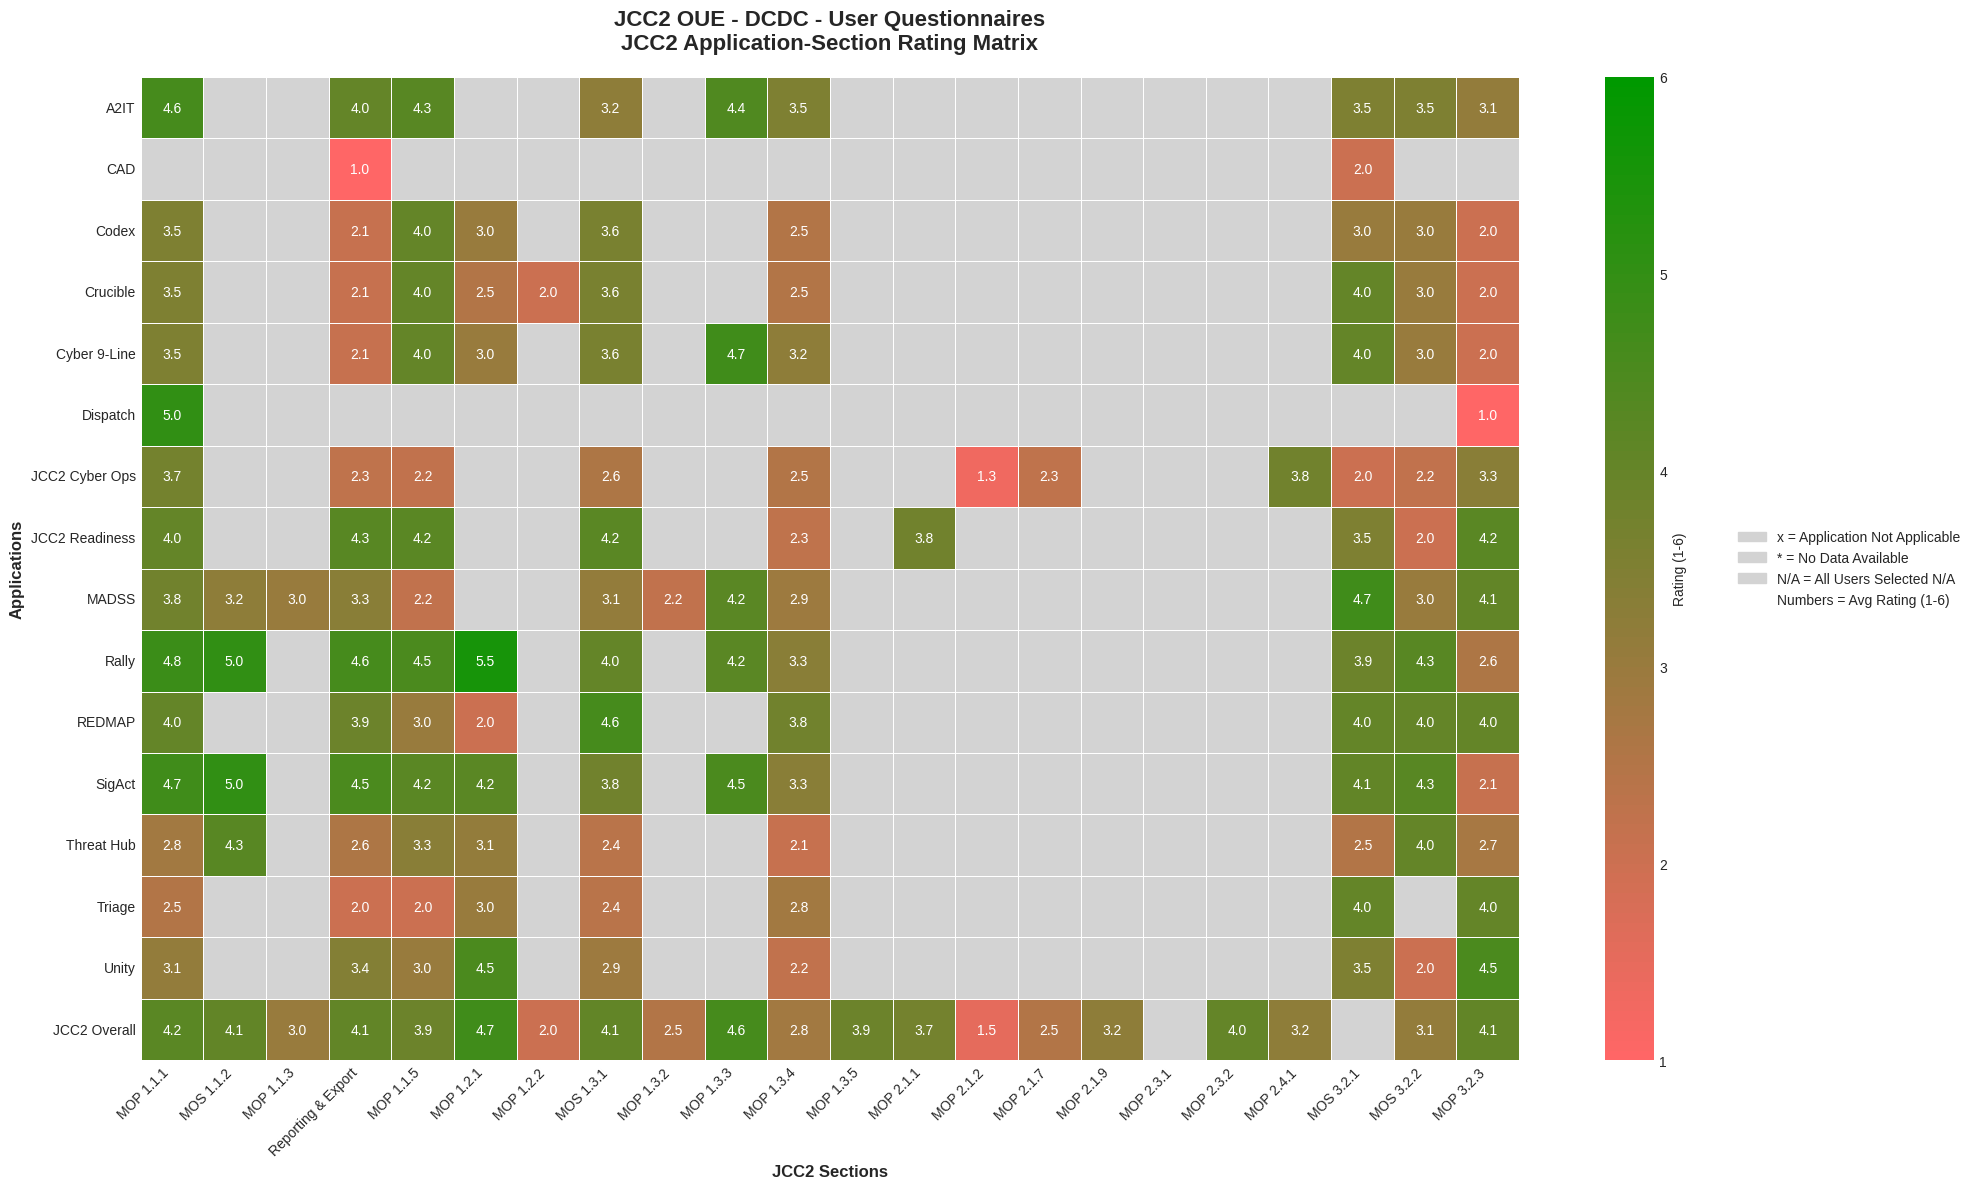

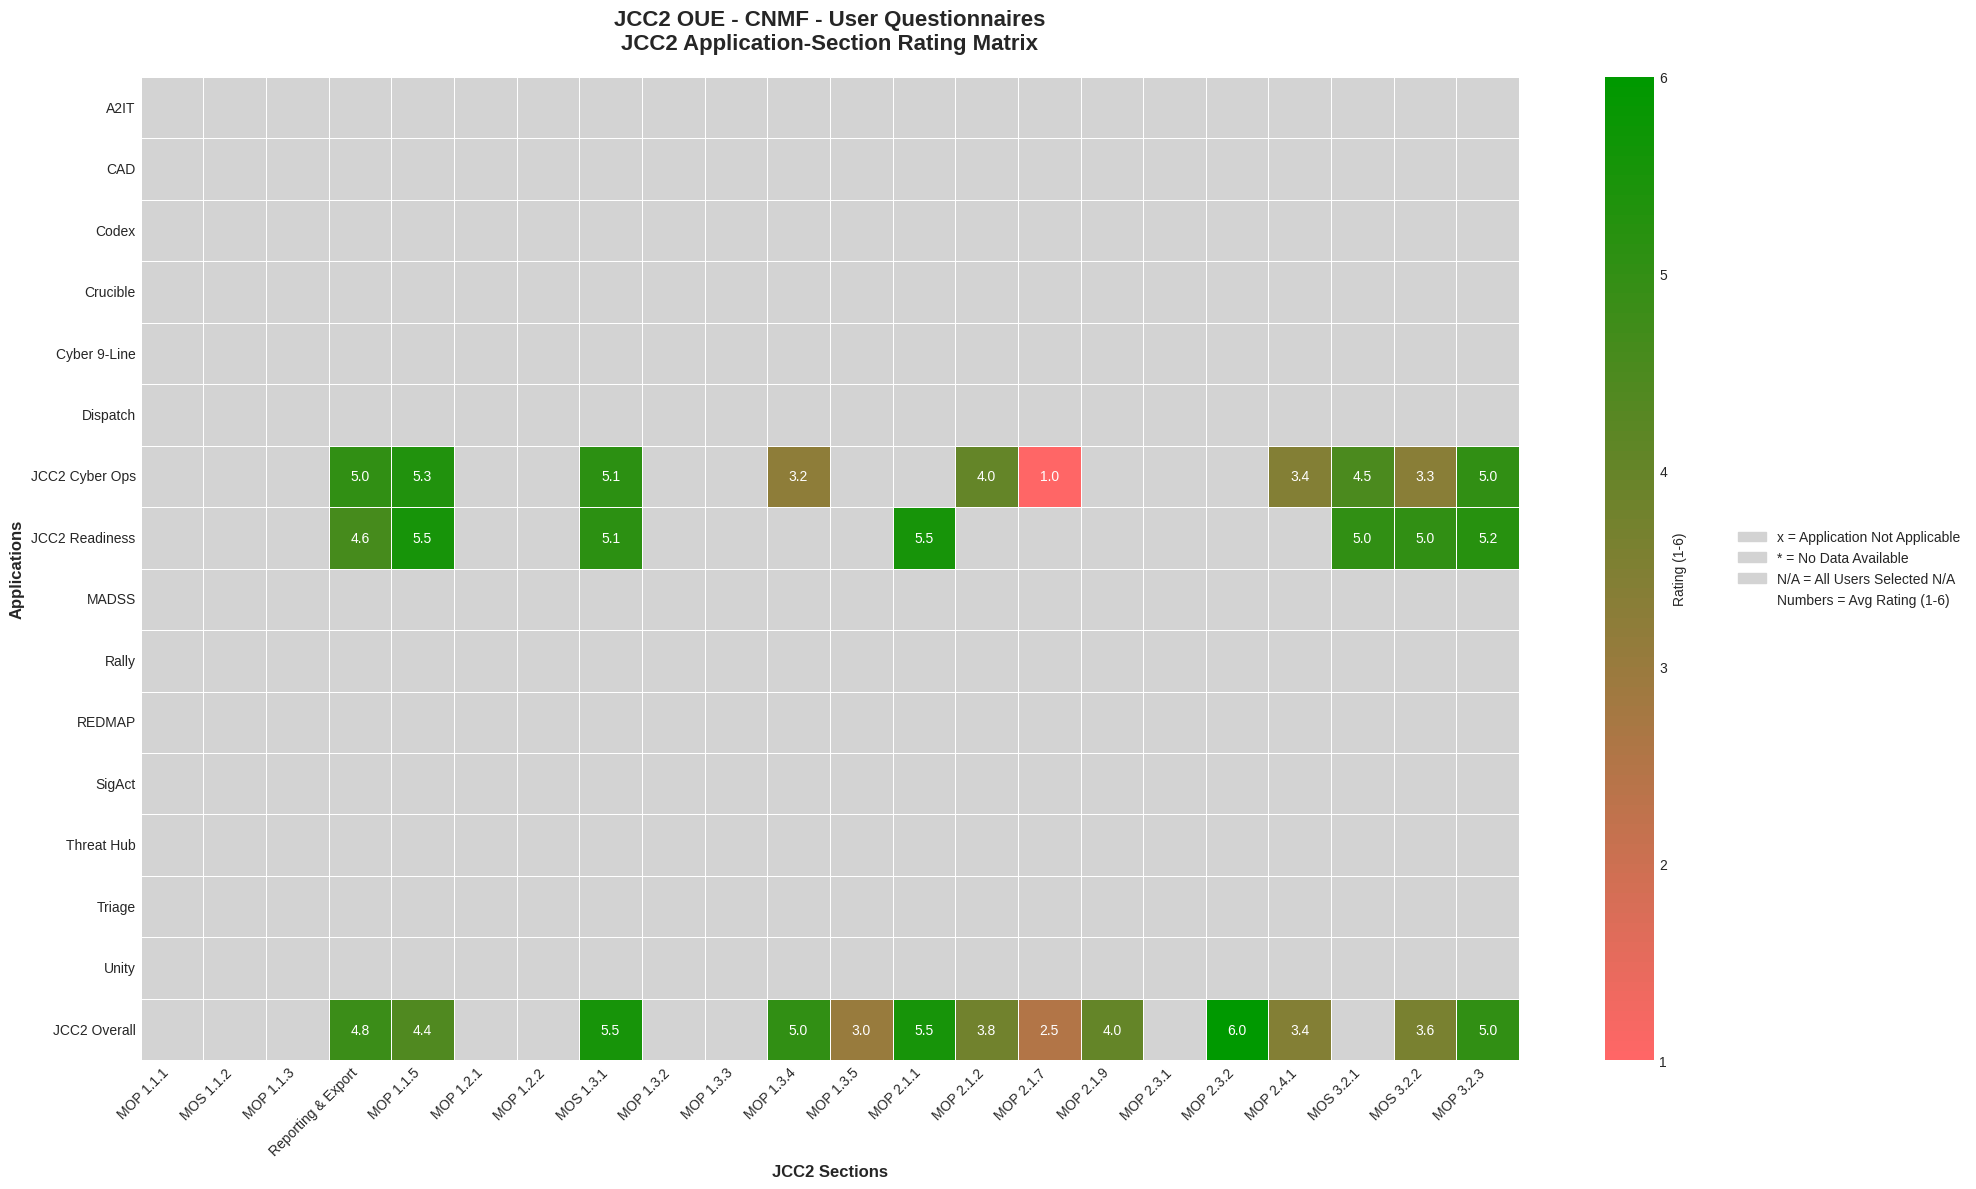

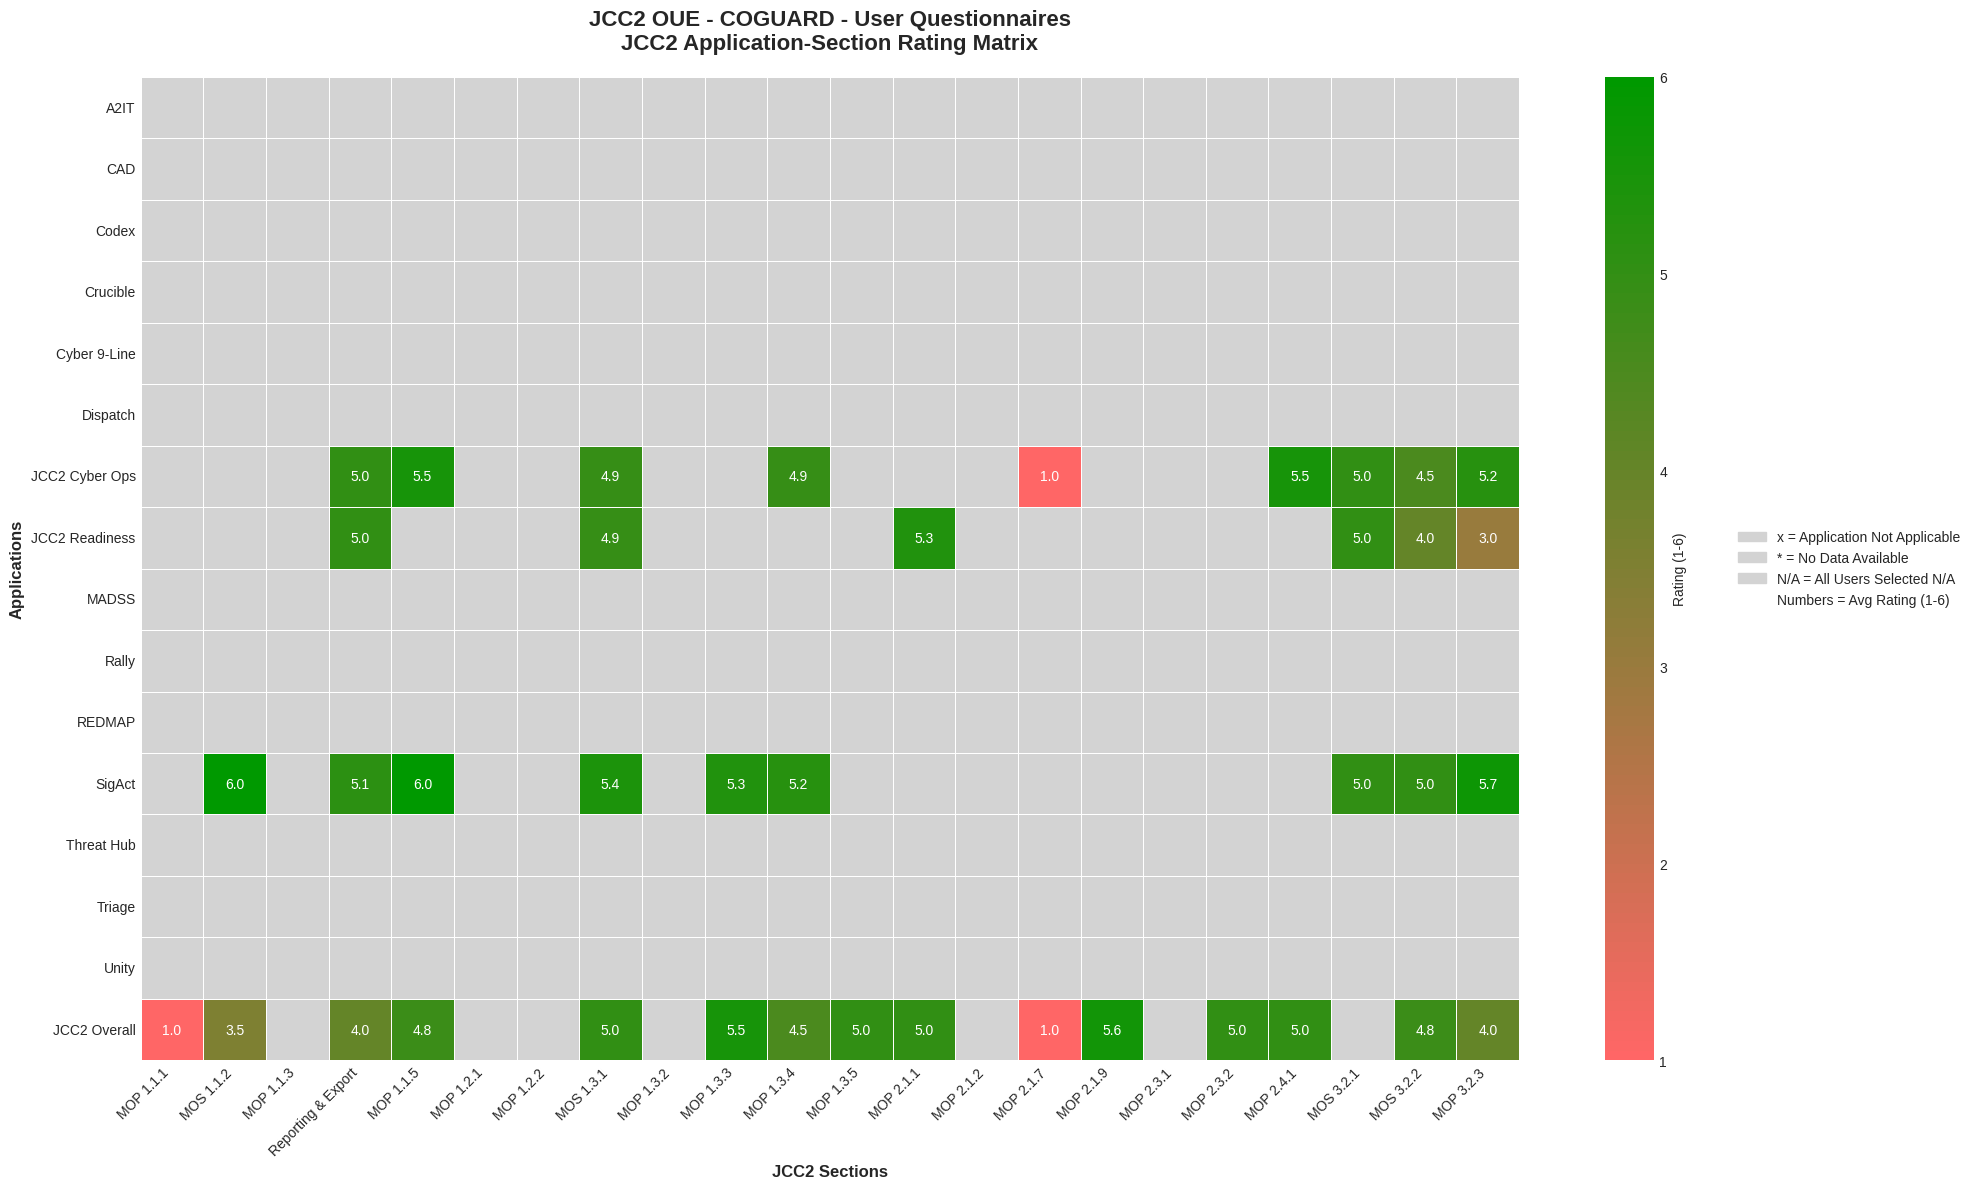

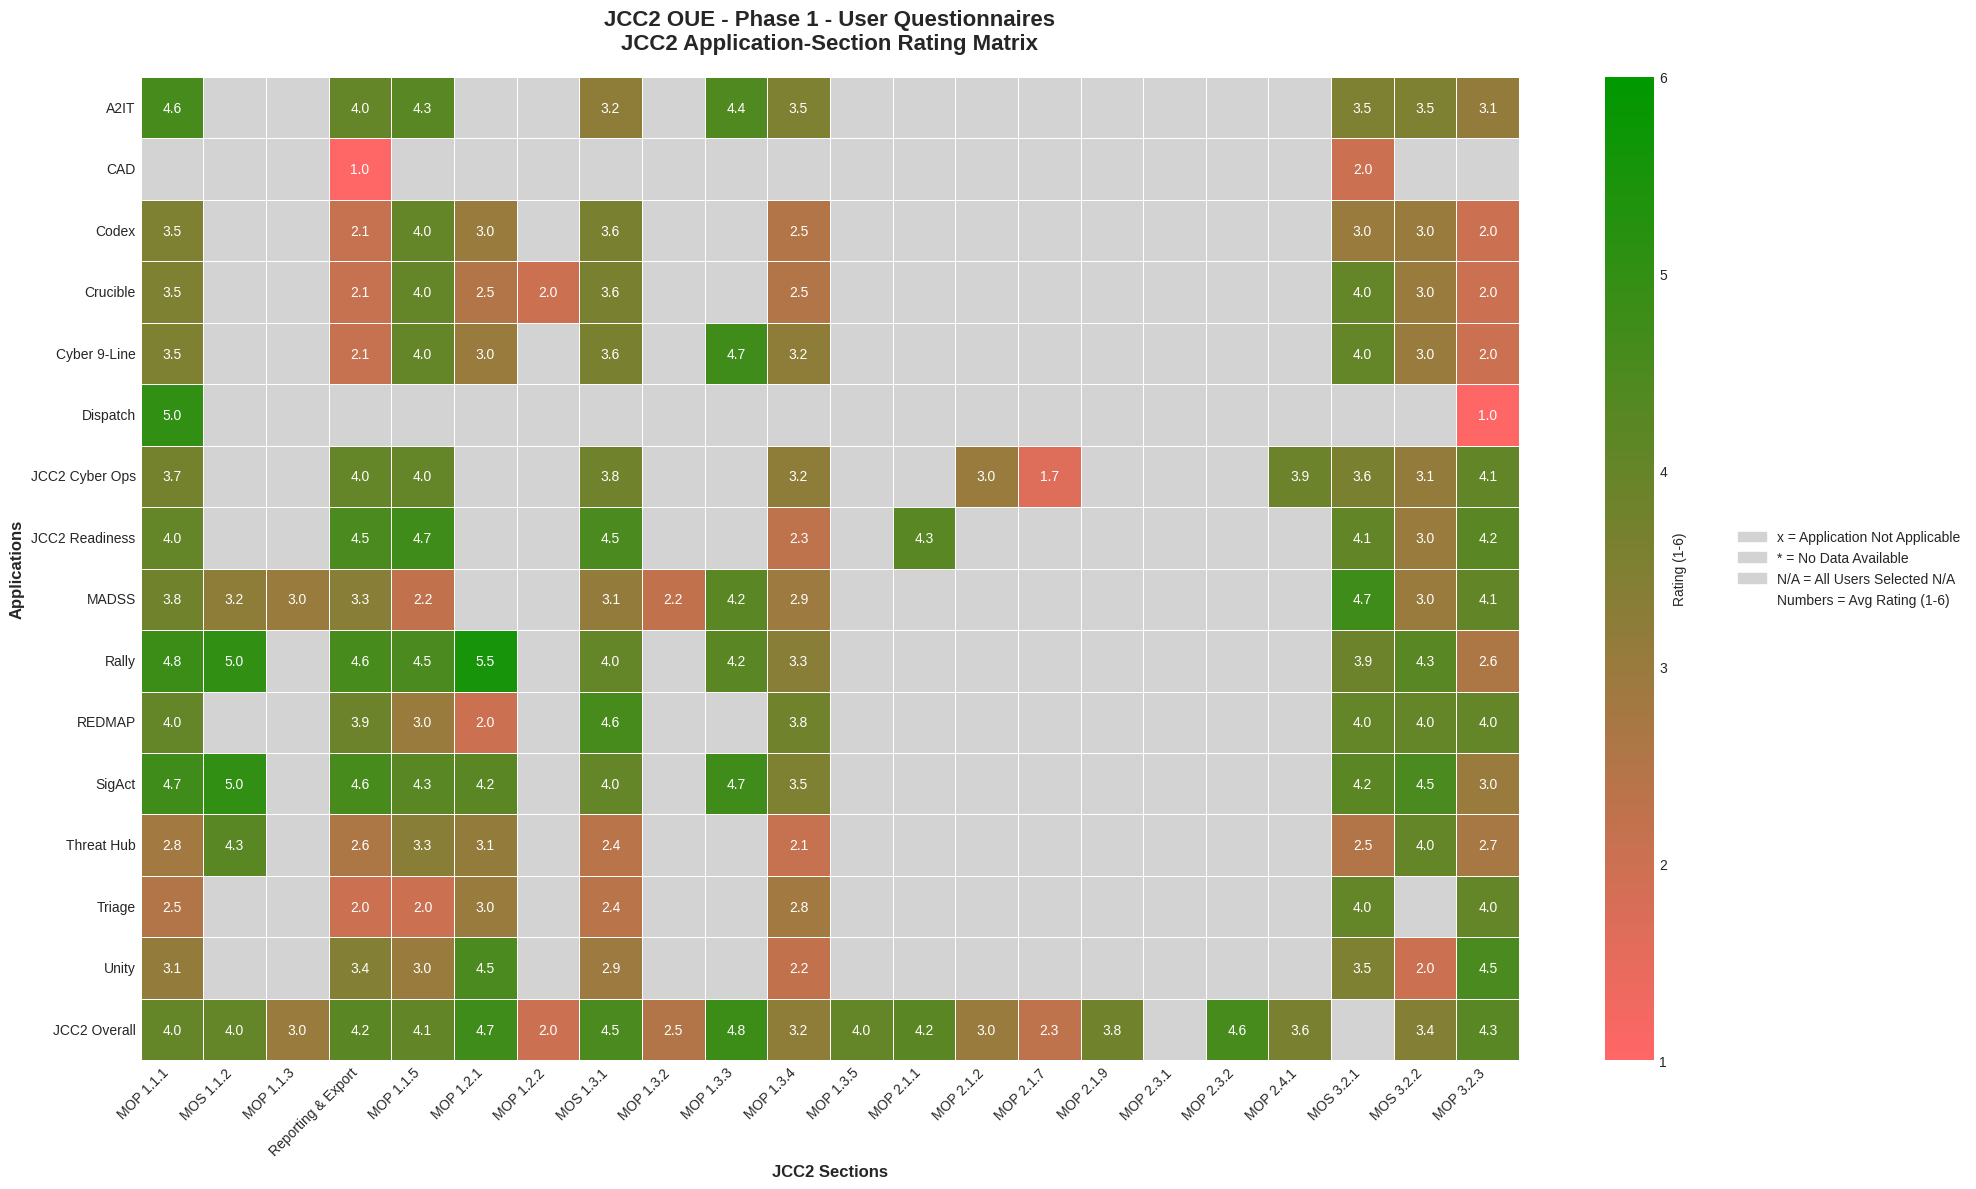

In [82]:
# Create individual heatmaps for each dataset
def create_dataset_heatmap(dataset_name, matrix_df, matrix_data, row_labels, column_labels):
    """Create a heatmap for a specific dataset"""
    
    # Convert matrix to numeric for visualization
    numeric_matrix = []
    annotation_matrix = []

    for row in matrix_data:
        numeric_row = []
        annot_row = []
        for val in row:
            if val == 'x':
                numeric_row.append(np.nan)  # Use NaN for grey cells
                annot_row.append('x')
            elif val == '*':
                numeric_row.append(np.nan)  # Use NaN for grey cells
                annot_row.append('*')
            elif val == 'N/A':
                numeric_row.append(np.nan)  # Use NaN for grey cells
                annot_row.append('N/A')
            else:
                try:
                    numeric_val = float(val)
                    numeric_row.append(numeric_val)
                    annot_row.append(val)  # Keep the original string format
                except:
                    numeric_row.append(np.nan)
                    annot_row.append('')
        numeric_matrix.append(numeric_row)
        annotation_matrix.append(annot_row)

    # Create figure
    fig, ax = plt.subplots(figsize=(20, 12))

    # Create custom colormap
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib.patches as mpatches

    # Define colors for the gradient (red to green)
    colors = ['#ff6666', '#009900']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('rating', colors, N=n_bins)
    
    # Set the color for NaN values (masked cells) to grey
    cmap.set_bad(color='#d3d3d3')

    # Create the DataFrames
    numeric_df = pd.DataFrame(numeric_matrix, index=row_labels, columns=column_labels)
    annot_df = pd.DataFrame(annotation_matrix, index=row_labels, columns=column_labels)
    
    # Plot heatmap with custom annotations
    sns.heatmap(numeric_df, annot=annot_df, fmt='', 
                cmap=cmap, vmin=1, vmax=6, cbar_kws={'label': 'Rating (1-6)'}, 
                linewidths=0.5, ax=ax, annot_kws={'size': 10})

    # Customize the plot
    ax.set_title(f'{dataset_name}\nJCC2 Application-Section Rating Matrix', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('JCC2 Sections', fontsize=12, fontweight='bold')
    ax.set_ylabel('Applications', fontsize=12, fontweight='bold')

    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Add legend for special symbols
    legend_elements = [
        mpatches.Patch(color='#d3d3d3', label='x = Application Not Applicable'),
        mpatches.Patch(color='#d3d3d3', label='* = No Data Available'),
        mpatches.Patch(color='#d3d3d3', label='N/A = All Users Selected N/A'),
        mpatches.Patch(color='white', label='Numbers = Avg Rating (1-6)')
    ]
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.15, 0.5))

    plt.tight_layout()
    return fig

# Generate heatmaps for all datasets
for dataset_name in all_matrices.keys():
    data = all_matrix_data[dataset_name]
    fig = create_dataset_heatmap(
        dataset_name, 
        all_matrices[dataset_name],
        data['matrix_data'],
        data['row_labels'],
        data['column_labels']
    )
    plt.show()
    plt.close()

# Visualization functions


Generating Comparative Analysis...


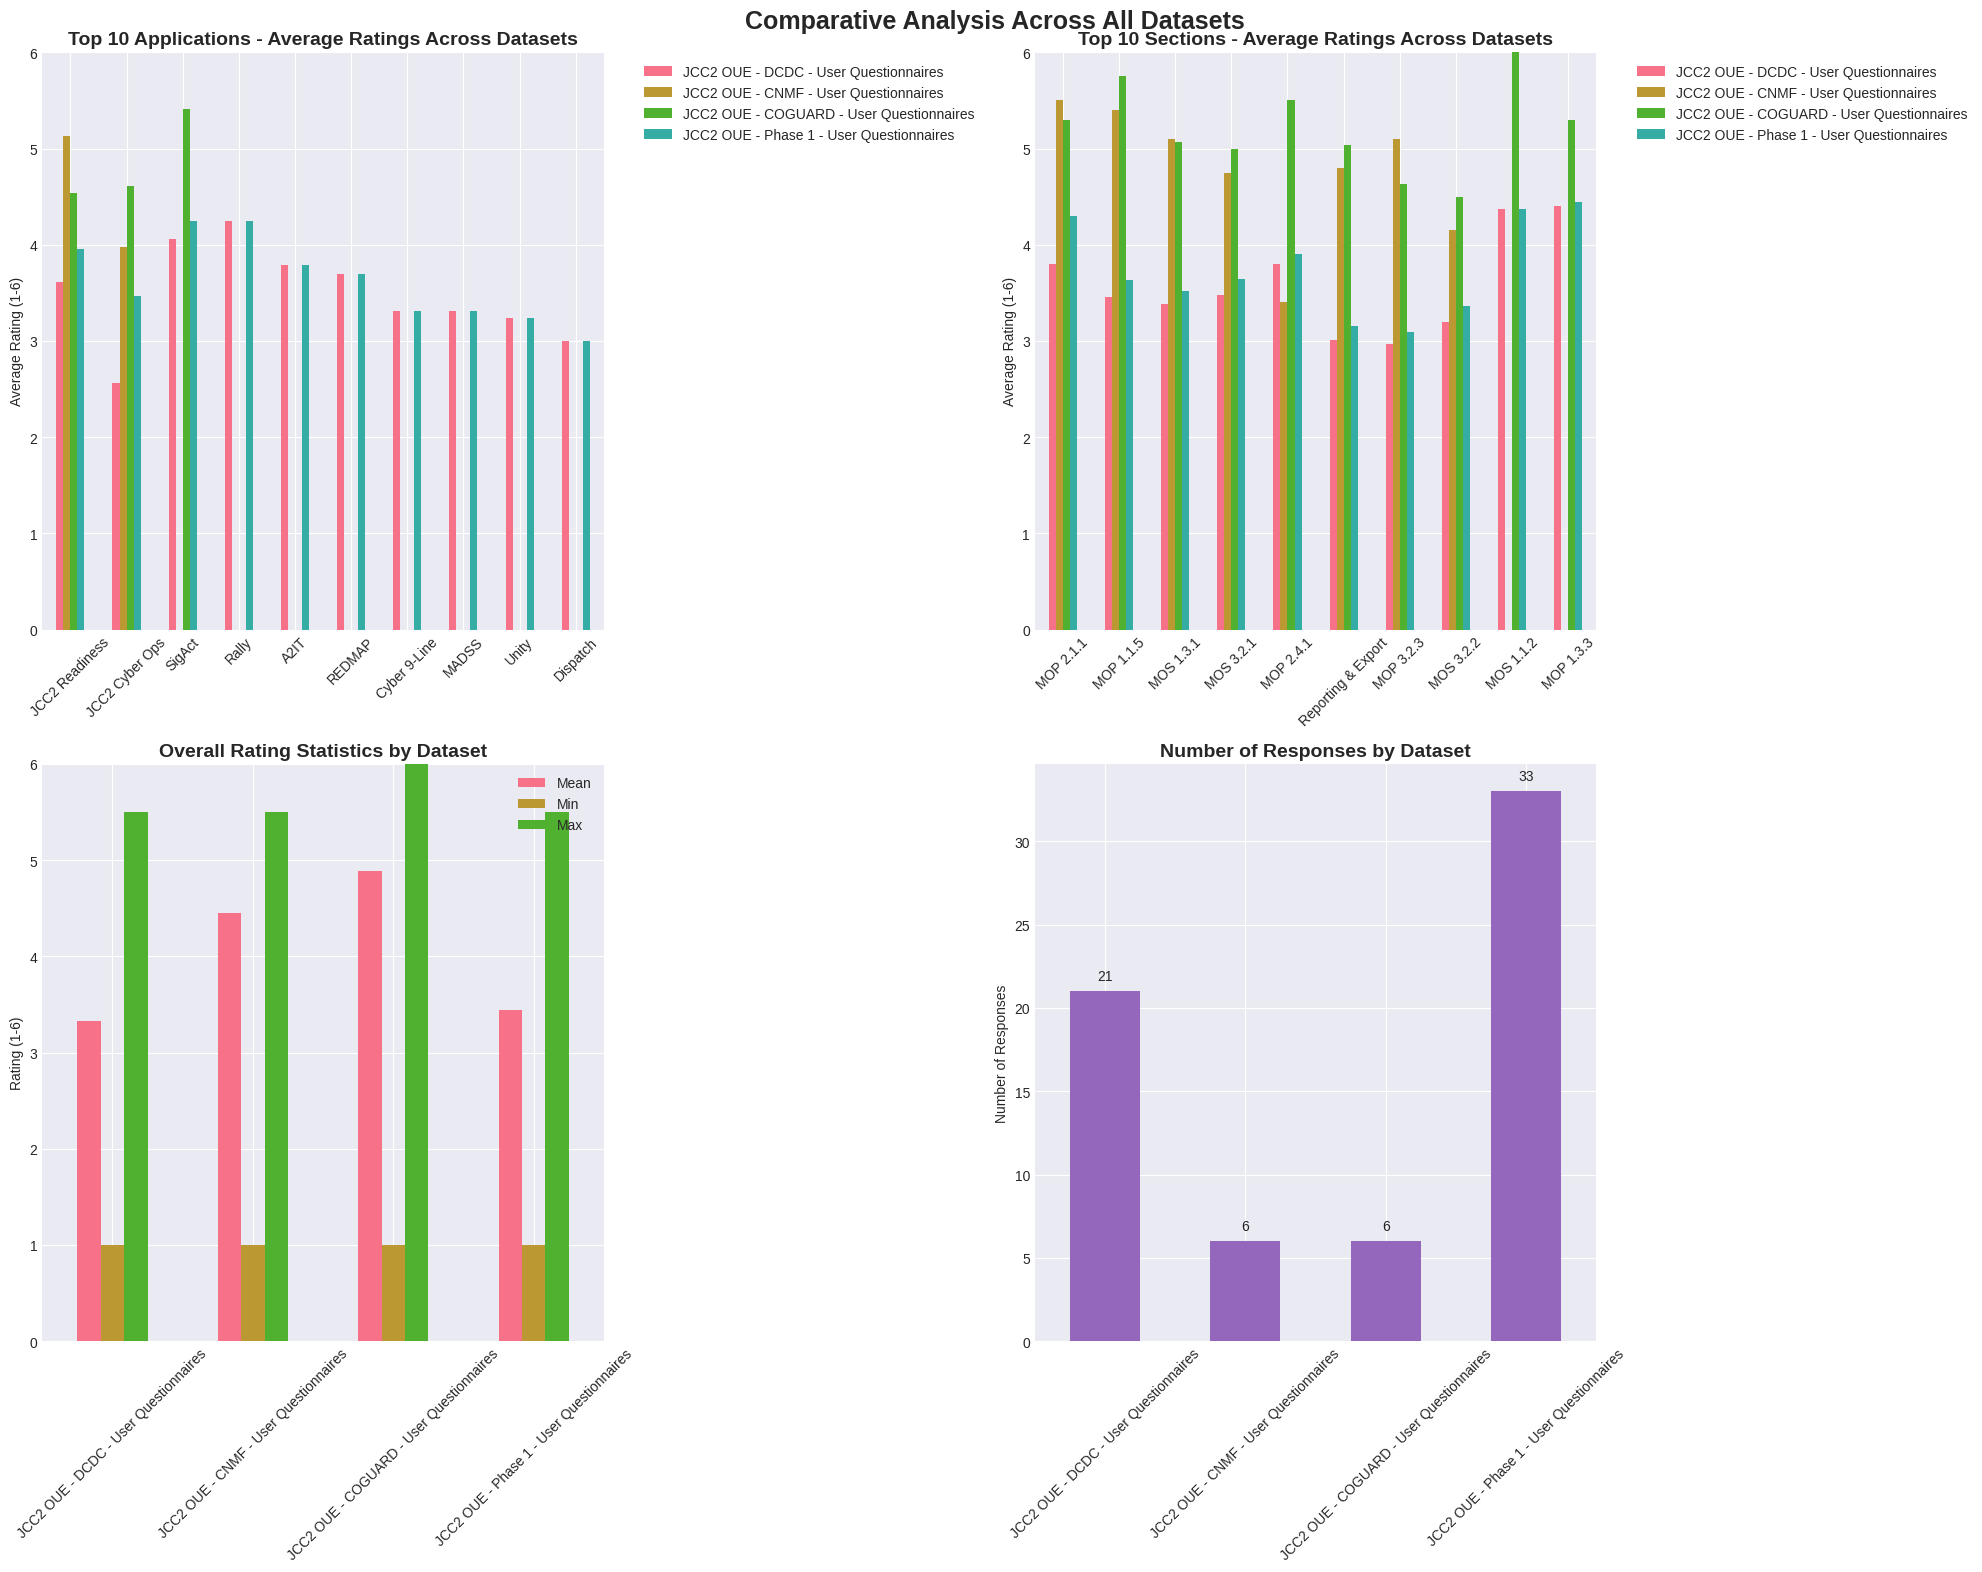



Application Ratings Comparison (Top 10):
JCC2 Readiness    4.31
JCC2 Cyber Ops    3.65
SigAct            3.43
Rally             2.12
A2IT              1.89
REDMAP            1.85
Cyber 9-Line      1.66
MADSS             1.65
Unity             1.62
Dispatch          1.50
dtype: float64


Section Ratings Comparison (Top 10):
MOP 2.1.1             4.73
MOP 1.1.5             4.56
MOS 1.3.1             4.27
MOS 3.2.1             4.22
MOP 2.4.1             4.15
Reporting & Export    4.00
MOP 3.2.3             3.95
MOS 3.2.2             3.80
MOS 1.1.2             3.69
MOP 1.3.3             3.53
dtype: float64


Overall Statistics by Dataset:
                                          Mean  Std Dev  Min  Max
JCC2 OUE - DCDC - User Questionnaires     3.32     0.94  1.0  5.5
JCC2 OUE - CNMF - User Questionnaires     4.45     1.13  1.0  5.5
JCC2 OUE - COGUARD - User Questionnaires  4.89     1.01  1.0  6.0
JCC2 OUE - Phase 1 - User Questionnaires  3.44     0.91  1.0  5.5


In [81]:
# Create comparative visualizations across datasets
def create_comparative_analysis():
    """Create visualizations comparing ratings across all datasets"""
    
    # 1. Application comparison across datasets
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Comparative Analysis Across All Datasets', fontsize=18, fontweight='bold')
    
    # Calculate average ratings per application for each dataset
    app_ratings_by_dataset = {}
    
    for dataset_name, data in all_matrix_data.items():
        matrix_data = data['matrix_data']
        row_labels = data['row_labels']
        
        app_ratings = {}
        for i, app in enumerate(row_labels[:-1]):  # Exclude JCC2 Overall
            row = matrix_data[i]
            ratings = []
            for val in row:
                try:
                    rating = float(val)
                    ratings.append(rating)
                except:
                    pass
            
            if ratings:
                app_ratings[app] = np.mean(ratings)
        
        app_ratings_by_dataset[dataset_name] = app_ratings
    
    # Create dataframe for comparison
    comparison_df = pd.DataFrame(app_ratings_by_dataset)
    comparison_df = comparison_df.fillna(0)  # Fill missing values with 0
    
    # Plot 1: Bar chart comparing top applications
    ax1 = axes[0, 0]
    top_apps = comparison_df.mean(axis=1).nlargest(10).index
    comparison_df.loc[top_apps].plot(kind='bar', ax=ax1)
    ax1.set_title('Top 10 Applications - Average Ratings Across Datasets', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Average Rating (1-6)')
    ax1.set_ylim(0, 6)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Section comparison across datasets
    ax2 = axes[0, 1]
    section_ratings_by_dataset = {}
    
    for dataset_name, data in all_matrix_data.items():
        matrix_data = data['matrix_data']
        column_labels = data['column_labels']
        
        section_ratings = {}
        for j, section in enumerate(column_labels):
            column_values = [matrix_data[i][j] for i in range(len(matrix_data)-1)]  # Exclude JCC2 Overall
            ratings = []
            for val in column_values:
                try:
                    rating = float(val)
                    ratings.append(rating)
                except:
                    pass
            
            if ratings:
                section_ratings[section] = np.mean(ratings)
        
        section_ratings_by_dataset[dataset_name] = section_ratings
    
    section_comparison_df = pd.DataFrame(section_ratings_by_dataset)
    section_comparison_df = section_comparison_df.fillna(0)
    
    # Select top sections
    top_sections = section_comparison_df.mean(axis=1).nlargest(10).index
    section_comparison_df.loc[top_sections].plot(kind='bar', ax=ax2)
    ax2.set_title('Top 10 Sections - Average Ratings Across Datasets', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Average Rating (1-6)')
    ax2.set_ylim(0, 6)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.tick_params(axis='x', rotation=45)
    
    # Plot 3: Overall statistics comparison
    ax3 = axes[1, 0]
    overall_stats = {}
    
    for dataset_name, data in all_matrix_data.items():
        matrix_data = data['matrix_data']
        all_ratings = []
        
        for row in matrix_data[:-1]:  # Exclude JCC2 Overall
            for val in row:
                try:
                    rating = float(val)
                    all_ratings.append(rating)
                except:
                    pass
        
        if all_ratings:
            overall_stats[dataset_name] = {
                'Mean': np.mean(all_ratings),
                'Std Dev': np.std(all_ratings),
                'Min': np.min(all_ratings),
                'Max': np.max(all_ratings)
            }
    
    stats_df = pd.DataFrame(overall_stats).T
    stats_df[['Mean', 'Min', 'Max']].plot(kind='bar', ax=ax3)
    ax3.set_title('Overall Rating Statistics by Dataset', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Rating (1-6)')
    ax3.set_ylim(0, 6)
    ax3.tick_params(axis='x', rotation=45)
    
    # Plot 4: Response count comparison
    ax4 = axes[1, 1]
    response_counts = {}
    
    for dataset_name in dataframes.keys():
        response_counts[dataset_name] = len(dataframes[dataset_name])
    
    pd.Series(response_counts).plot(kind='bar', ax=ax4, color=COLORS['tertiary'])
    ax4.set_title('Number of Responses by Dataset', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Number of Responses')
    ax4.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for i, (dataset, count) in enumerate(response_counts.items()):
        ax4.text(i, count + 0.5, str(count), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df, section_comparison_df, stats_df

# Generate comparative analysis
print("\nGenerating Comparative Analysis...")
print("=" * 80)
app_comparison_df, section_comparison_df, stats_df = create_comparative_analysis()

# Display summary tables
print("\n\nApplication Ratings Comparison (Top 10):")
print(app_comparison_df.mean(axis=1).nlargest(10).round(2))

print("\n\nSection Ratings Comparison (Top 10):")
print(section_comparison_df.mean(axis=1).nlargest(10).round(2))

print("\n\nOverall Statistics by Dataset:")
print(stats_df.round(2))

# Comparative analysis across datasets

In [73]:
# Generate detailed summary statistics for each dataset
def generate_dataset_statistics(dataset_name, matrix_data, row_labels, column_labels):
    """Generate comprehensive statistics for a single dataset"""
    
    print(f"\n{'='*80}")
    print(f"Summary Statistics for: {dataset_name}")
    print(f"{'='*80}")
    
    # Application statistics
    app_stats = []
    for i, app in enumerate(row_labels[:-1]):  # Exclude JCC2 Overall
        row = matrix_data[i]
        ratings = []
        for val in row:
            try:
                rating = float(val)
                ratings.append(rating)
            except:
                pass
        
        if ratings:
            app_stats.append({
                'Application': app,
                'Avg Rating': np.mean(ratings),
                'Min Rating': min(ratings),
                'Max Rating': max(ratings),
                'Sections Rated': len(ratings),
                'Not Applicable': row.count('x'),
                'No Data': row.count('*'),
                'User NA': row.count('N/A')
            })
    
    app_stats_df = pd.DataFrame(app_stats)
    if not app_stats_df.empty:
        app_stats_df = app_stats_df.sort_values('Avg Rating', ascending=False)
        print("\nApplication Performance Summary:")
        print(app_stats_df.to_string(index=False))
    
    # Section statistics
    section_stats = []
    for j, section in enumerate(column_labels):
        column_values = [matrix_data[i][j] for i in range(len(matrix_data)-1)]  # Exclude JCC2 Overall
        ratings = []
        for val in column_values:
            try:
                rating = float(val)
                ratings.append(rating)
            except:
                pass
        
        if ratings:
            section_stats.append({
                'Section': section,
                'Avg Rating': np.mean(ratings),
                'Min Rating': min(ratings),
                'Max Rating': max(ratings),
                'Apps Rated': len(ratings),
                'Not Applicable': column_values.count('x'),
                'No Data': column_values.count('*'),
                'User NA': column_values.count('N/A')
            })
    
    section_stats_df = pd.DataFrame(section_stats)
    if not section_stats_df.empty:
        section_stats_df = section_stats_df.sort_values('Avg Rating', ascending=False)
        print("\nSection Performance Summary:")
        print(section_stats_df.to_string(index=False))
    
    # Overall statistics
    all_ratings = []
    for row in matrix_data[:-1]:  # Exclude JCC2 Overall
        for val in row:
            try:
                rating = float(val)
                all_ratings.append(rating)
            except:
                pass
    
    if all_ratings:
        print(f"\nOverall Dataset Statistics:")
        print(f"  - Total Ratings: {len(all_ratings)}")
        print(f"  - Average Rating: {np.mean(all_ratings):.2f}")
        print(f"  - Standard Deviation: {np.std(all_ratings):.2f}")
        print(f"  - Minimum Rating: {min(all_ratings):.1f}")
        print(f"  - Maximum Rating: {max(all_ratings):.1f}")
        print(f"  - Median Rating: {np.median(all_ratings):.2f}")
    
    return app_stats_df, section_stats_df

# Generate statistics for all datasets
all_app_stats = {}
all_section_stats = {}

for dataset_name, data in all_matrix_data.items():
    app_stats, section_stats = generate_dataset_statistics(
        dataset_name,
        data['matrix_data'],
        data['row_labels'],
        data['column_labels']
    )
    all_app_stats[dataset_name] = app_stats
    all_section_stats[dataset_name] = section_stats


Summary Statistics for: JCC2 OUE - DCDC - User Questionnaires

Application Performance Summary:
   Application  Avg Rating  Min Rating  Max Rating  Sections Rated  Not Applicable  No Data  User NA
         Rally    4.245455         2.6         5.5              11              11        0        0
        SigAct    4.063636         2.1         5.0              11              11        0        0
          A2IT    3.788889         3.1         4.6               9              12        0        1
        REDMAP    3.700000         2.0         4.6               9              13        0        0
JCC2 Readiness    3.611111         2.0         4.3               9              13        0        0
  Cyber 9-Line    3.310000         2.0         4.7              10              12        0        0
         MADSS    3.308333         2.2         4.7              12              10        0        0
         Unity    3.233333         2.0         4.5               9              13        0    

# Detailed statistics generation

In [74]:
# Export all results to files
import os
from datetime import datetime

# Create output directory
output_dir = 'jcc2_matrix_analysis_output'
os.makedirs(output_dir, exist_ok=True)

# Create timestamp for filenames
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Export individual matrices
for dataset_name, matrix_df in all_matrices.items():
    # Clean filename
    clean_name = dataset_name.replace(' - ', '_').replace(' ', '_').replace('/', '_')
    
    # Export matrix
    matrix_filename = f"{output_dir}/{clean_name}_matrix_{timestamp}.csv"
    matrix_df.to_csv(matrix_filename)
    print(f"Exported matrix for {dataset_name} to: {matrix_filename}")
    
    # Export detailed report
    detailed_report = []
    data = all_matrix_data[dataset_name]
    matrix_data = data['matrix_data']
    row_labels = data['row_labels']
    column_labels = data['column_labels']
    
    for i, app in enumerate(row_labels):
        for j, section in enumerate(column_labels):
            value = matrix_data[i][j]
            detailed_report.append({
                'Application': app,
                'Section': section,
                'Rating': value,
                'Status': 'Not Applicable' if value == 'x' else 
                         'No Data' if value == '*' else 
                         'User NA' if value == 'N/A' else 'Rated'
            })
    
    detailed_df = pd.DataFrame(detailed_report)
    detailed_filename = f"{output_dir}/{clean_name}_detailed_{timestamp}.csv"
    detailed_df.to_csv(detailed_filename, index=False)
    print(f"Exported detailed report for {dataset_name} to: {detailed_filename}")

# Export comparative analysis
comparison_filename = f"{output_dir}/comparative_analysis_{timestamp}.xlsx"
with pd.ExcelWriter(comparison_filename, engine='openpyxl') as writer:
    # Application comparison
    app_comparison_df.to_excel(writer, sheet_name='Application_Comparison')
    
    # Section comparison
    section_comparison_df.to_excel(writer, sheet_name='Section_Comparison')
    
    # Overall statistics
    stats_df.to_excel(writer, sheet_name='Overall_Statistics')
    
    # Response counts
    response_counts_df = pd.DataFrame({
        'Dataset': list(dataframes.keys()),
        'Response_Count': [len(df) for df in dataframes.values()]
    })
    response_counts_df.to_excel(writer, sheet_name='Response_Counts', index=False)

print(f"\nExported comparative analysis to: {comparison_filename}")

# Create summary report
summary_report = f"""
JCC2 Application-Section Matrix Analysis Report
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

DATASETS ANALYZED:
"""

for dataset_name, df in dataframes.items():
    summary_report += f"\n- {dataset_name}: {len(df)} responses"

summary_report += f"\n\nOUTPUT FILES GENERATED:"
summary_report += f"\n- Individual matrix files: {len(all_matrices)} files"
summary_report += f"\n- Individual detailed reports: {len(all_matrices)} files"
summary_report += f"\n- Comparative analysis: {comparison_filename}"

summary_report += "\n\nTOP PERFORMING APPLICATIONS (Average across all datasets):"
top_apps = app_comparison_df.mean(axis=1).nlargest(5)
for app, rating in top_apps.items():
    summary_report += f"\n- {app}: {rating:.2f}"

summary_report += "\n\nTOP PERFORMING SECTIONS (Average across all datasets):"
top_sections = section_comparison_df.mean(axis=1).nlargest(5)
for section, rating in top_sections.items():
    summary_report += f"\n- {section}: {rating:.2f}"

# Save summary report
summary_filename = f"{output_dir}/analysis_summary_{timestamp}.txt"
with open(summary_filename, 'w') as f:
    f.write(summary_report)

print(f"\nSaved summary report to: {summary_filename}")
print("\nAll exports completed successfully!")

Exported matrix for JCC2 OUE - DCDC - User Questionnaires to: jcc2_matrix_analysis_output/JCC2_OUE_DCDC_User_Questionnaires_matrix_20250803_124004.csv
Exported detailed report for JCC2 OUE - DCDC - User Questionnaires to: jcc2_matrix_analysis_output/JCC2_OUE_DCDC_User_Questionnaires_detailed_20250803_124004.csv
Exported matrix for JCC2 OUE - CNMF - User Questionnaires to: jcc2_matrix_analysis_output/JCC2_OUE_CNMF_User_Questionnaires_matrix_20250803_124004.csv
Exported detailed report for JCC2 OUE - CNMF - User Questionnaires to: jcc2_matrix_analysis_output/JCC2_OUE_CNMF_User_Questionnaires_detailed_20250803_124004.csv
Exported matrix for JCC2 OUE - COGUARD - User Questionnaires to: jcc2_matrix_analysis_output/JCC2_OUE_COGUARD_User_Questionnaires_matrix_20250803_124004.csv
Exported detailed report for JCC2 OUE - COGUARD - User Questionnaires to: jcc2_matrix_analysis_output/JCC2_OUE_COGUARD_User_Questionnaires_detailed_20250803_124004.csv
Exported matrix for JCC2 OUE - Phase 1 - User Que

# Export results to files

## Summary

This notebook generates comprehensive matrices showing the relationship between JCC2 applications and evaluation sections across multiple datasets. 

### Key Features:
1. **Multi-Dataset Analysis**: Processes multiple questionnaire datasets simultaneously
2. **Application-Section Matrices**: Shows ratings for each application in each section
3. **Visual Heatmaps**: Color-coded visualization of ratings across applications and sections
4. **Comparative Analysis**: Cross-dataset comparisons to identify trends and patterns
5. **Statistical Summaries**: Detailed performance metrics for applications and sections
6. **Data Export**: Comprehensive export functionality for further analysis

### Output:
- Individual rating matrices for each dataset
- Visual heatmaps with clear rating scales
- Comparative analysis charts across datasets
- Detailed CSV and Excel exports with all results
- Summary statistics and performance metrics